Split the dataset into training and test set for fair comparison between the models

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import random


In [2]:
# Step 1: Define Dataset and DataLoader
data_dir = 'data'

In [3]:
# Transformations: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Load Dataset
dataset = ImageFolder(root=data_dir, transform=transform)
torch.save(dataset, "dataset.pth")

IAM split

In [6]:
import random
from collections import defaultdict

# 1. Raggruppa indici per writer_id (label originali)
writer_to_indices = defaultdict(list)
for idx, sample in enumerate(dataset):
    writer_to_indices[sample[1]].append(idx)

# 2. Escludi utenti con meno di tre campioni
filtered_writer_to_indices = {w: s for w, s in writer_to_indices.items() if len(s) > 2}

# 3. Lista utenti rimasti e split autorizzati/non autorizzati
all_writer_ids = list(filtered_writer_to_indices.keys())
random.seed(19)
random.shuffle(all_writer_ids)

split_index = int(0.8 * len(all_writer_ids))
authorized_writers = set(all_writer_ids[:split_index])
unauthorized_writers = set(all_writer_ids[split_index:])

# 4. Crea indici train/test
train_indices = []
test_auth_samples = []  # test samples autorizzati
test_unauth_samples = []  # test samples non autorizzati (1 per utente)

for writer in authorized_writers:
    indices = filtered_writer_to_indices[writer]
    random.shuffle(indices)
    n = len(indices)
    
    if n == 3:
        train_split = 2
    elif n == 4:
        train_split = 3
    else:
        train_split = int(n * 0.8)
    
    # Safety net: assicurati almeno 1 sample in test
    if n - train_split < 1:
        train_split = n - 1

    train_indices.extend(indices[:train_split])
    test_auth_samples.extend(indices[train_split:])

for writer in unauthorized_writers:
    # prendi un solo campione casuale per ogni utente non autorizzato
    sample = random.choice(filtered_writer_to_indices[writer])
    test_unauth_samples.append(sample)

# Combina test set bilanciato
test_indices = test_auth_samples + test_unauth_samples
random.shuffle(test_indices)

print(f"Train set: {len(train_indices)} campioni (solo autorizzati)")
print(f"Test set: {len(test_indices)} campioni (autorizzati + non)")

# 5. Crea label_map SOLO per gli utenti nel training set
train_labels_orig = [dataset[idx][1] for idx in train_indices]
unique_train_labels = sorted(set(train_labels_orig))

label_map = {orig_label: new_label for new_label, orig_label in enumerate(unique_train_labels)}

# 6. (facoltativo) Ricodifica i label del test set: -1 per utenti non autorizzati
test_labels_orig = [dataset[idx][1] for idx in test_indices]
test_labels_mapped = [
    label_map[label] if label in label_map else -1
    for label in test_labels_orig
]


Train set: 567 campioni (solo autorizzati)
Test set: 201 campioni (autorizzati + non)


Plot IAM distribution info

🧾 Statistiche principali
- Utenti autorizzati: 127
  ↳ Campioni totali nel train set: 567
  ↳ Utenti nel train set: 127
  ↳ Utenti autorizzati nel test set: 127
  ↳ Campioni autorizzati nel test set: 169
  ↳ Media campioni test per utente autorizzato: 1.33
- Utenti non autorizzati totali: 32
  ↳ Utenti non autorizzati nel test set: 32
  ↳ Campioni non autorizzati nel test set: 32


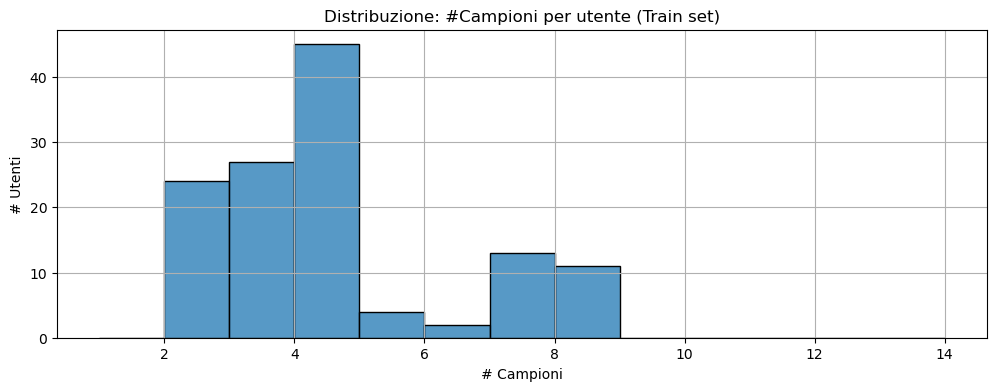

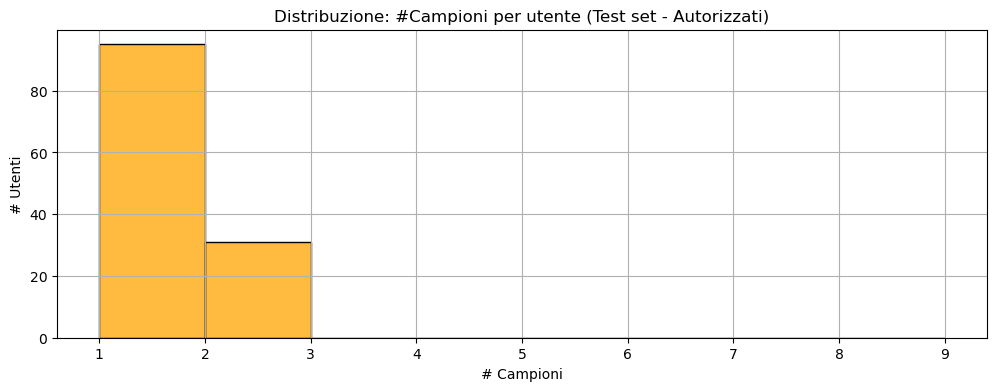

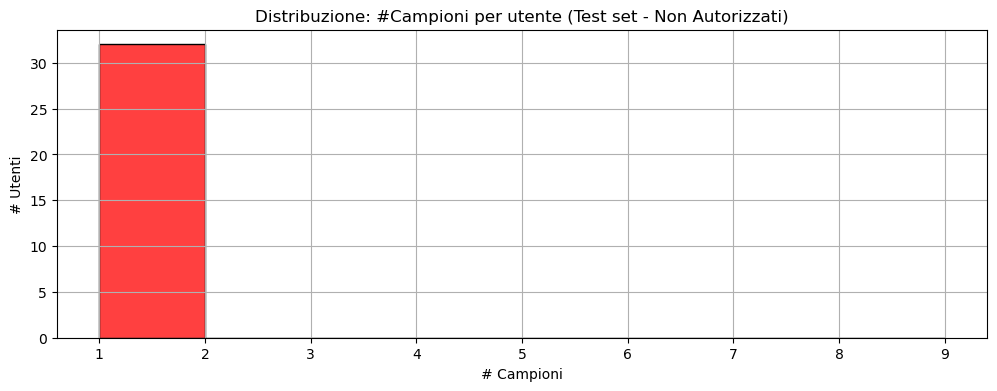

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def get_writer_id(idx):
    return dataset[idx][1]

# Ricostruisci i writer_id
train_writer_ids = [get_writer_id(i) for i in train_indices]
test_writer_ids = [get_writer_id(i) for i in test_indices]

# Separazione test: autorizzati vs non autorizzati
test_auth_ids = [i for i in test_writer_ids if i in authorized_writers]
test_unauth_ids = [i for i in test_writer_ids if i in unauthorized_writers]

# Conta campioni per utente
train_count = Counter(train_writer_ids)
test_auth_count = Counter(test_auth_ids)
test_unauth_count = Counter(test_unauth_ids)

# Statistiche generali
print("🧾 Statistiche principali")
print(f"- Utenti autorizzati: {len(authorized_writers)}")
print(f"  ↳ Campioni totali nel train set: {len(train_indices)}")
print(f"  ↳ Utenti nel train set: {len(train_count)}")
print(f"  ↳ Utenti autorizzati nel test set: {len(test_auth_count)}")

# Nuovi calcoli aggiunti qui
num_test_auth_samples = sum(test_auth_count.values())
mean_test_auth_samples = num_test_auth_samples / len(test_auth_count) if len(test_auth_count) > 0 else 0

print(f"  ↳ Campioni autorizzati nel test set: {num_test_auth_samples}")
print(f"  ↳ Media campioni test per utente autorizzato: {mean_test_auth_samples:.2f}")

print(f"- Utenti non autorizzati totali: {len(unauthorized_writers)}")
print(f"  ↳ Utenti non autorizzati nel test set: {len(test_unauth_count)}")
print(f"  ↳ Campioni non autorizzati nel test set: {sum(test_unauth_count.values())}")

# ————————————————————————————————————————————————————
# 📊 1. Istogramma: campioni per utente (train)
plt.figure(figsize=(12, 4))
sns.histplot(list(train_count.values()), bins=range(1, 15), kde=False)
plt.title("Distribuzione: #Campioni per utente (Train set)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

# 📊 2. Istogramma: campioni per utente (Test - Autorizzati)
plt.figure(figsize=(12, 4))
sns.histplot(list(test_auth_count.values()), bins=range(1, 10), kde=False, color='orange')
plt.title("Distribuzione: #Campioni per utente (Test set - Autorizzati)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

# 📊 3. Istogramma: campioni per utente (Test - Non autorizzati)
plt.figure(figsize=(12, 4))
sns.histplot(list(test_unauth_count.values()), bins=range(1, 10), kde=False, color='red')
plt.title("Distribuzione: #Campioni per utente (Test set - Non Autorizzati)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()


Save IAM split

In [8]:
import torch
import os

split = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'label_map': label_map
}

os.makedirs('splits', exist_ok=True)
torch.save(split, 'splits/dataset_split.pth')


Train set: 8166 campioni
Test set: 2521 campioni
🧾 Statistiche principali
- Utenti autorizzati: 1092
  ↳ Campioni nel train set: 8166
  ↳ Campioni autorizzati nel test set: 2248
- Utenti non autorizzati: 273
  ↳ Campioni non autorizzati nel test set: 273


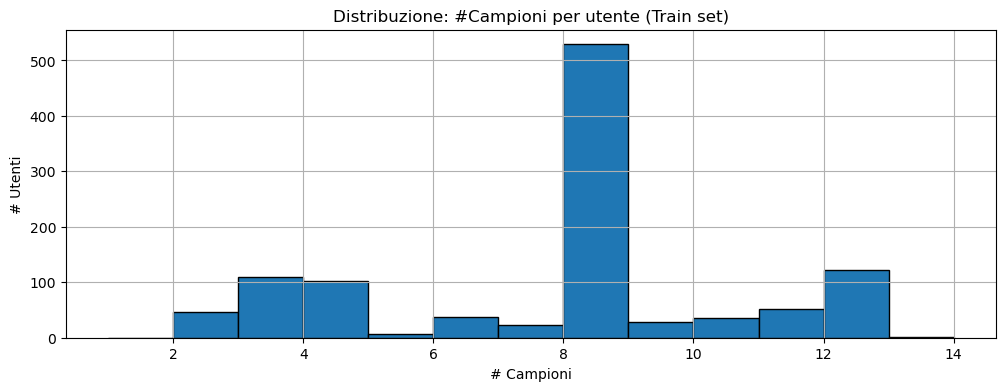

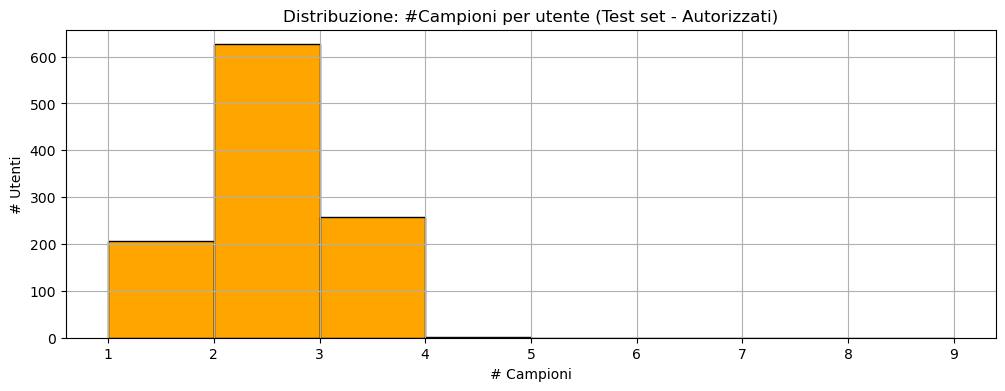

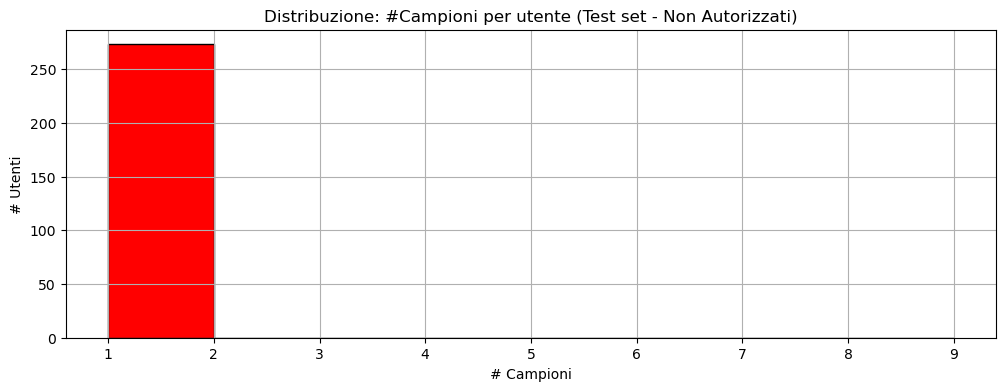

In [1]:
import torch
import os
import random
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torchvision import transforms, datasets

# -----------------------------
# 🔹 Percorso merged dataset
# -----------------------------
data_dir = '../merged_dataset'  # cartelle IAM + RIMES dentro

# Trasformazioni immagini
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carica dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# -----------------------------
# 🔹 Split per writer
# -----------------------------
writer_to_indices = defaultdict(list)
for idx, sample in enumerate(dataset):
    writer_to_indices[sample[1]].append(idx)

# Escludi utenti con <3 campioni
filtered_writer_to_indices = {w: s for w, s in writer_to_indices.items() if len(s) > 2}

# Shuffle writer
all_writer_ids = list(filtered_writer_to_indices.keys())
random.seed(19)
random.shuffle(all_writer_ids)

split_index = int(0.8 * len(all_writer_ids))
authorized_writers = set(all_writer_ids[:split_index])
unauthorized_writers = set(all_writer_ids[split_index:])

train_indices, test_auth_samples, test_unauth_samples = [], [], []

for writer in authorized_writers:
    indices = filtered_writer_to_indices[writer]
    random.shuffle(indices)
    n = len(indices)

    if n == 3:
        train_split = 2
    elif n == 4:
        train_split = 3
    else:
        train_split = int(n * 0.8)

    if n - train_split < 1:
        train_split = n - 1

    train_indices.extend(indices[:train_split])
    test_auth_samples.extend(indices[train_split:])

for writer in unauthorized_writers:
    sample = random.choice(filtered_writer_to_indices[writer])
    test_unauth_samples.append(sample)

test_indices = test_auth_samples + test_unauth_samples
random.shuffle(test_indices)

print(f"Train set: {len(train_indices)} campioni")
print(f"Test set: {len(test_indices)} campioni")

# -----------------------------
# 🔹 Statistiche
# -----------------------------
def get_writer_id(idx):
    return dataset[idx][1]

train_writer_ids = [get_writer_id(i) for i in train_indices]
test_writer_ids = [get_writer_id(i) for i in test_indices]

test_auth_ids = [i for i in test_writer_ids if i in authorized_writers]
test_unauth_ids = [i for i in test_writer_ids if i in unauthorized_writers]

train_count = Counter(train_writer_ids)
test_auth_count = Counter(test_auth_ids)
test_unauth_count = Counter(test_unauth_ids)

print("🧾 Statistiche principali")
print(f"- Utenti autorizzati: {len(authorized_writers)}")
print(f"  ↳ Campioni nel train set: {len(train_indices)}")
print(f"  ↳ Campioni autorizzati nel test set: {sum(test_auth_count.values())}")
print(f"- Utenti non autorizzati: {len(unauthorized_writers)}")
print(f"  ↳ Campioni non autorizzati nel test set: {sum(test_unauth_count.values())}")

# -----------------------------
# 🔹 Plot solo con matplotlib
# -----------------------------
plt.figure(figsize=(12, 4))
plt.hist(list(train_count.values()), bins=range(1, 15), edgecolor='black')
plt.title("Distribuzione: #Campioni per utente (Train set)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(list(test_auth_count.values()), bins=range(1, 10), edgecolor='black', color='orange')
plt.title("Distribuzione: #Campioni per utente (Test set - Autorizzati)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(list(test_unauth_count.values()), bins=range(1, 10), edgecolor='black', color='red')
plt.title("Distribuzione: #Campioni per utente (Test set - Non Autorizzati)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

# -----------------------------
# 🔹 Salvataggio split
# -----------------------------
split = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'label_map': {orig: i for i, orig in enumerate(sorted(set(train_writer_ids)))}
}
os.makedirs('splits', exist_ok=True)
torch.save(split, 'splits/merged_dataset_split.pth')


In [16]:
print("Numero totale di classi (writer):", len(dataset.classes))
print("Prime 20 classi:", dataset.classes[:20])
print("Totale campioni:", len(dataset.samples))

Numero totale di classi (writer): 657
Prime 20 classi: ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019']
Totale campioni: 1539


IAM+RIMES split

In [6]:
import torch
import os
import random
from collections import Counter, defaultdict
import torch
import os
import random
from collections import defaultdict, Counter
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# -----------------------------
# 🔹 Percorso merged dataset
# -----------------------------
data_dir = '../../merged_dataset'  # IAM + RIMES già uniti

# Trasformazioni immagini
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Parametri
max_authorized = 200
max_unauthorized = 50

# Carica dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Conta campioni per writer
writer_to_indices = defaultdict(list)
for idx, sample in enumerate(dataset):
    writer_to_indices[sample[1]].append(idx)

# Filtra autori con almeno 2 campioni
filtered_writer_to_indices = {w: idxs for w, idxs in writer_to_indices.items() if len(idxs) >= 2}

# Classifica gli autori per numero di campioni (discendente)
sorted_writers = sorted(filtered_writer_to_indices.items(), key=lambda x: len(x[1]), reverse=True)

# Identifica se writer è IAM o RIMES
def writer_source(writer_id):
    # supponiamo che IAM abbia id numerici, RIMES id stringhe → adatta se serve
    return "IAM" if str(writer_id).isdigit() else "RIMES"

iam_writers = [w for w, idxs in sorted_writers if writer_source(w) == "IAM"]
rimes_writers = [w for w, idxs in sorted_writers if writer_source(w) == "RIMES"]

# Seleziona bilanciato IAM+RIMES
n_iam = max_authorized // 2
n_rimes = max_authorized - n_iam
authorized_writers = set(iam_writers[:n_iam] + rimes_writers[:n_rimes])

# Gli altri diventano non autorizzati
unauthorized_writers = set(w for w, _ in sorted_writers if w not in authorized_writers)
if len(unauthorized_writers) > max_unauthorized:
    unauthorized_writers = set(random.sample(list(unauthorized_writers), max_unauthorized))

# -----------------------------
# Creazione train/test indices
# -----------------------------
train_indices, test_auth_samples, test_unauth_samples = [], [], []

# Autorizzati: n-1 campioni train, 1 test
for writer in authorized_writers:
    indices = filtered_writer_to_indices[writer]
    random.shuffle(indices)
    train_indices.extend(indices[:-1])  # tutti tranne 1
    test_auth_samples.append(indices[-1])  # ultimo per test

# Non autorizzati: 1 campione per writer nel test
for writer in unauthorized_writers:
    indices = filtered_writer_to_indices[writer]
    sample = random.choice(indices)
    test_unauth_samples.append(sample)

# Combina test set
test_indices = test_auth_samples + test_unauth_samples
random.shuffle(test_indices)

print(f"Train set: {len(train_indices)} campioni (solo autorizzati)")
print(f"Test set: {len(test_indices)} campioni (autorizzati + non)")

# -----------------------------
# Statistiche
# -----------------------------
train_writer_ids = [dataset[idx][1] for idx in train_indices]
test_writer_ids = [dataset[idx][1] for idx in test_indices]

test_auth_ids = [i for i in test_writer_ids if i in authorized_writers]
test_unauth_ids = [i for i in test_writer_ids if i in unauthorized_writers]

train_count = Counter(train_writer_ids)
test_auth_count = Counter(test_auth_ids)
test_unauth_count = Counter(test_unauth_ids)

print("🧾 Statistiche principali")
print(f"- Utenti autorizzati: {len(authorized_writers)}")
print(f"  ↳ Campioni nel train set: {len(train_indices)}")
print(f"  ↳ Campioni autorizzati nel test set: {sum(test_auth_count.values())}")
print(f"- Utenti non autorizzati: {len(unauthorized_writers)}")
print(f"  ↳ Campioni non autorizzati nel test set: {sum(test_unauth_count.values())}")

# -----------------------------
# Salvataggio split
# -----------------------------
label_map = {orig: i for i, orig in enumerate(sorted(authorized_writers))}  # solo autorizzati
split = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'label_map': label_map
}
os.makedirs('splits', exist_ok=True)
torch.save(split, 'splits/merged_dataset_split_improved.pth')


Train set: 604 campioni (solo autorizzati)
Test set: 150 campioni (autorizzati + non)
🧾 Statistiche principali
- Utenti autorizzati: 100
  ↳ Campioni nel train set: 604
  ↳ Campioni autorizzati nel test set: 100
- Utenti non autorizzati: 50
  ↳ Campioni non autorizzati nel test set: 50


In [1]:
import torch
import os
import random
from collections import defaultdict, Counter
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# -----------------------------
# 🔹 Percorso merged dataset
# -----------------------------
data_dir = '../../IAM+RIMES'  # IAM + RIMES già uniti

# Trasformazioni immagini
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Parametri
max_authorized = 200
max_unauthorized = 50

# Carica dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Conta campioni per writer
writer_to_indices = defaultdict(list)
for idx, sample in enumerate(dataset):
    writer_to_indices[sample[1]].append(idx)

# -----------------------------
# 🔹 Escludi writer "000" (IAM)
# -----------------------------
# Trova il label index associato a "000" (se presente)
writer_name_to_idx = dataset.class_to_idx  # mappa {nome_cartella: indice}
if "000" in writer_name_to_idx:
    idx_000 = writer_name_to_idx["000"]
    if idx_000 in writer_to_indices:
        del writer_to_indices[idx_000]
    print("⚠️ Writer '000' escluso dal dataset")

# Filtra autori con almeno 2 campioni
filtered_writer_to_indices = {w: idxs for w, idxs in writer_to_indices.items() if len(idxs) >= 2}

# Classifica gli autori per numero di campioni (discendente)
sorted_writers = sorted(filtered_writer_to_indices.items(), key=lambda x: len(x[1]), reverse=True)

# Identifica se writer è IAM o RIMES
def writer_source(writer_id):
    # supponiamo che IAM abbia id numerici, RIMES id stringhe → adatta se serve
    return "IAM" if str(writer_id).isdigit() else "RIMES"

iam_writers = [w for w, idxs in sorted_writers if writer_source(w) == "IAM"]
rimes_writers = [w for w, idxs in sorted_writers if writer_source(w) == "RIMES"]

# Seleziona bilanciato IAM+RIMES
n_iam = max_authorized // 2
n_rimes = max_authorized - n_iam
authorized_writers = set(iam_writers[:n_iam] + rimes_writers[:n_rimes])

# Gli altri diventano non autorizzati
unauthorized_writers = set(w for w, _ in sorted_writers if w not in authorized_writers)
if len(unauthorized_writers) > max_unauthorized:
    unauthorized_writers = set(random.sample(list(unauthorized_writers), max_unauthorized))

# -----------------------------
# Creazione train/test indices
# -----------------------------
train_indices, test_auth_samples, test_unauth_samples = [], [], []

# Autorizzati: n-1 campioni train, 1 test
for writer in authorized_writers:
    indices = filtered_writer_to_indices[writer]
    random.shuffle(indices)
    train_indices.extend(indices[:-1])  # tutti tranne 1
    test_auth_samples.append(indices[-1])  # ultimo per test

# Non autorizzati: 1 campione per writer nel test
for writer in unauthorized_writers:
    indices = filtered_writer_to_indices[writer]
    sample = random.choice(indices)
    test_unauth_samples.append(sample)

# Combina test set
test_indices = test_auth_samples + test_unauth_samples
random.shuffle(test_indices)

print(f"Train set: {len(train_indices)} campioni (solo autorizzati)")
print(f"Test set: {len(test_indices)} campioni (autorizzati + non)")

# -----------------------------
# Statistiche
# -----------------------------
train_writer_ids = [dataset[idx][1] for idx in train_indices]
test_writer_ids = [dataset[idx][1] for idx in test_indices]

test_auth_ids = [i for i in test_writer_ids if i in authorized_writers]
test_unauth_ids = [i for i in test_writer_ids if i in unauthorized_writers]

train_count = Counter(train_writer_ids)
test_auth_count = Counter(test_auth_ids)
test_unauth_count = Counter(test_unauth_ids)

print("🧾 Statistiche principali")
print(f"- Utenti autorizzati: {len(authorized_writers)}")
print(f"  ↳ Campioni nel train set: {len(train_indices)}")
print(f"  ↳ Campioni autorizzati nel test set: {sum(test_auth_count.values())}")
print(f"- Utenti non autorizzati: {len(unauthorized_writers)}")
print(f"  ↳ Campioni non autorizzati nel test set: {sum(test_unauth_count.values())}")

# -----------------------------
# Salvataggio split
# -----------------------------
label_map = {orig: i for i, orig in enumerate(sorted(authorized_writers))}  # solo autorizzati
split = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'label_map': label_map
}
os.makedirs('splits', exist_ok=True)
torch.save(split, 'splits/merged_dataset_split_improved.pth')


⚠️ Writer '000' escluso dal dataset
Train set: 550 campioni (solo autorizzati)
Test set: 150 campioni (autorizzati + non)
🧾 Statistiche principali
- Utenti autorizzati: 100
  ↳ Campioni nel train set: 550
  ↳ Campioni autorizzati nel test set: 100
- Utenti non autorizzati: 50
  ↳ Campioni non autorizzati nel test set: 50


Debug

In [ ]:
import os
from PIL import Image
from collections import Counter, defaultdict

root = '../merged_dataset'

sizes = Counter()
by_writer_count = Counter()
unknown_count = 0
sample_dim = defaultdict(list)

for writer in os.listdir(root):
    wdir = os.path.join(root, writer)
    if not os.path.isdir(wdir): 
        continue
    files = [f for f in os.listdir(wdir) if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]
    by_writer_count[writer] += len(files)
    if 'unknown' in writer.lower():
        unknown_count += len(files)
    # campiona poche immagini per writer
    for f in files[:3]:
        p = os.path.join(wdir,f)
        try:
            with Image.open(p) as im:
                sizes[(im.width, im.height)] += 1
                sample_dim[writer].append((im.width, im.height))
        except:
            pass

print('Top 10 dimensioni:', sizes.most_common(10))
print('Writer totali:', len(by_writer_count))
print('Immagini totali:', sum(by_writer_count.values()))
print('Immagini in classi *_unknown:', unknown_count)
big = sum(1 for wh,c in sizes.items() if max(wh) > 1000)
print('Numero di formati “grandi” (max side > 1000):', big)


Top 10 dimensioni: [((2479, 3542), 1115), ((2472, 3505), 66), ((2472, 3504), 65), ((2475, 3505), 63), ((2474, 3504), 60), ((2473, 3504), 57), ((2474, 3505), 56), ((2471, 3504), 55), ((2471, 3503), 55), ((2473, 3503), 54)]
Writer totali: 2066
Immagini totali: 14139
Immagini in classi *_unknown: 0
Numero di formati “grandi” (max side > 1000): 404


In [ ]:
import os

data_dir = "../../IAM+RIMES"

# 1. Conta le sottocartelle (writer)
all_writers = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"📂 Numero totale di writer (sottocartelle): {len(all_writers)}")

# 2. Conta immagini per ciascun writer
writer_image_counts = {}
for writer in all_writers:
    writer_path = os.path.join(data_dir, writer)
    n_images = len([f for f in os.listdir(writer_path) if os.path.isfile(os.path.join(writer_path, f))])
    writer_image_counts[writer] = n_images

# 3. Statistiche generali
writers_with_3plus = [w for w, n in writer_image_counts.items() if n >= 3]
print(f"👤 Writer con almeno 3 immagini: {len(writers_with_3plus)}")
print(f"👤 Writer con meno di 3 immagini: {len(all_writers) - len(writers_with_3plus)}")

# 4. (Opzionale) Mostra i primi 20 writer con numero di immagini
print("\nEsempio primi 20 writer e numero di immagini:")
for w in list(writer_image_counts.keys())[:20]:
    print(f"{w}: {writer_image_counts[w]}")


📂 Numero totale di writer (sottocartelle): 2067
👤 Writer con almeno 3 immagini: 1221
👤 Writer con meno di 3 immagini: 846

Esempio primi 20 writer e numero di immagini:
000: 59
001: 2
002: 1
003: 2
004: 1
005: 2
006: 1
007: 2
008: 2
009: 2
010: 2
011: 2
012: 2
013: 3
014: 2
015: 1
016: 3
017: 3
018: 2
019: 3


In [ ]:
import os

data_dir = "../../merged_dataset"

writers = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

writers_with_3_or_more = [
    w for w in writers if len(os.listdir(os.path.join(data_dir, w))) >= 4
]

print(f"Numero totale writer: {len(writers)}")
print(f"Numero writer con almeno 3 campioni: {len(writers_with_3_or_more)}")


Numero totale writer: 658
Numero writer con almeno 3 campioni: 128
